In [25]:
import os, sys
import numpy as np
import re
import pandas as pd

import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.style.use('ggplot')

caffe_root = '/home/ashu/Desktop/Thesis Work/Classifier/caffe/'
print os.getcwd()
sys.path.insert(0, caffe_root + 'python')
import caffe

import argparse

from caffe.proto import caffe_pb2
import google.protobuf as pb2
import google.protobuf.text_format

import lmdb
from collections import defaultdict
from sklearn.metrics import confusion_matrix

/home/ashu/Desktop/Thesis Work/Classifier/caffe/models/script


In [26]:
def compute_average_prec(rec, prec):
    
    # Correct Method
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
         mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

- Load the labels (val.txt)

In [27]:
#Set the path to labels file
cls_lbl_file = caffe_root + 'data/gen_data/labels/gen_umbrella_val.txt'
# read the labels file
with open(cls_lbl_file, 'r') as f:
    cls_data=f.readlines()
    
cls_data = [x.strip() for x in cls_data]

# append image name and its label in a dictionary
cls_lbl = {}
for val in cls_data:
    img, lbl = val.split(' ')
    cls_lbl[img] = lbl
    
print len(cls_data), len(cls_lbl)

5911 5911


- create prototxt and caffe model filename
- create the transformer as well

- create 2 list to carry tp and fp for each class
- 2D list indexed acc to class label
- loop through each file in val txt, load class label and feed fwd image
- take predictions and acc to class label update app tp and fp
- end all list ll be of unequal size
- cal prec and recall at each point and finally compute avg precision

In [28]:
caffe.set_mode_gpu()

img_dir = caffe_root + 'data/gen_data/images/'

# Modify the paths given below
deploy_prototxt_file_path = caffe_root + 'models/gt_classifier/gen_umbrella/test.prototxt' # Network definition file

iteration = range(1000, 41000, 1000)
df = pd.DataFrame(columns=['#Iteration','Open','Closed','mAP'])

for it in iteration:
    caffe_model_file_path = caffe_root + 'models/gt_classifier/gen_umbrella/trained_model' + \
                            '/gen_umbrella_' +  str(max(iteration)) + \
                            '_iter_' + str(it) + '.caffemodel'
    
    net = caffe.Net(deploy_prototxt_file_path, caffe_model_file_path, caffe.TEST)
    
    # set the transformeer
    # load the mean ImageNet image (as distributed with Caffe) for subtraction
    mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
    print 'mean-subtracted values:', zip('BGR', mu)

    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

    net.blobs['data'].reshape(1,        # batch size
                              3,         # 3-channel (BGR) images
                              224, 224)  # image size is 227x227
    
    tp = [[] for _ in range(2)]  #binary one hot vector to capture tp for each labels
    fp = [[] for _ in range(2)]  #binary one hot vector to capture fp for each labels
    p_score = [[] for _ in range(2)] #vector to store predicted score for sorting
    
    for k,v in cls_lbl.iteritems():
        
        # load image, transform and feed forward
        image = caffe.io.load_image(img_dir + k)
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image
        output = net.forward()
        plabel = int(output['prob'][0].argmax(axis=0))
        score = float(output['prob'][0].max(axis=0))
        label = int(v)
        
        # Assign tp and fp to appropiate list
        if plabel == 0 : # Open state
            p_score[plabel].append(score)
            if label == 0:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
        elif plabel == 1: # Closed state
            p_score[plabel].append(score)
            if label == 1:
                tp[plabel].append(1)
                fp[plabel].append(0)
            else:
                fp[plabel].append(1)
                tp[plabel].append(0)
                
    # count tp fp for each and avg prec
    ap = []
    for i in range(2):
        print i, len(tp[i]), len(fp[i])
        npos = len(tp[i])
        
        # conver to numpy array
        new_tp = np.array(tp[i])
        new_fp = np.array(fp[i])        
        new_score = np.array(p_score[i])
        
        #get sorted indices of open and close acc to score
        sorted_ind = np.argsort(-new_score)
        
        new_tp = new_tp[sorted_ind]
        new_fp = new_fp[sorted_ind]
        
        new_fp = np.cumsum(new_fp)
        new_tp = np.cumsum(new_tp)
        
        rec = new_tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        prec = new_tp / np.maximum(new_tp + new_fp, np.finfo(np.float64).eps)
        
        ap.append(compute_average_prec(rec, prec)) 
        print 'Average Precision for ' + str(i) + ' : ', ap[i]
    
    print 'Mean AP: ', np.mean(ap)        
    data = {'#Iteration' : it, 'Open' : ap[0], 'Closed' : ap[1], 'mAP' : np.mean(ap)}
    
    df = df.append(data, ignore_index=True)

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2680 2680
Average Precision for 0 :  0.822583051116
1 3231 3231
Average Precision for 1 :  0.808883991191
Mean AP:  0.815733521154
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2318 2318
Average Precision for 0 :  0.896795718534
1 3593 3593
Average Precision for 1 :  0.781555827517
Mean AP:  0.839175773026
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2593 2593
Average Precision for 0 :  0.853950163691
1 3318 3318
Average Precision for 1 :  0.812148242485
Mean AP:  0.833049203088
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2657 2657
Average Precision for 0 :  0.855795483012
1 3254 3254
Average Precision for 1 :  0.832559023326
Mean AP:  0.844177253169
mean-subtracted values: [('B', 104.0069879317889), (

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2675 2675
Average Precision for 0 :  0.871446552657
1 3236 3236
Average Precision for 1 :  0.853474910976
Mean AP:  0.862460731817
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2679 2679
Average Precision for 0 :  0.870043988964
1 3232 3232
Average Precision for 1 :  0.853527257718
Mean AP:  0.861785623341
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2684 2684
Average Precision for 0 :  0.869820335663
1 3227 3227
Average Precision for 1 :  0.854529501021
Mean AP:  0.862174918342
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
0 2691 2691
Average Precision for 0 :  0.868857306693
1 3220 3220
Average Precision for 1 :  0.855404889362
Mean AP:  0.862131098027
mean-subtracted values: [('B', 104.0069879317889), (

In [22]:
print df

    #Iteration      Open    Closed       mAP
0       1000.0  0.892783  0.740135  0.816459
1       2000.0  0.895121  0.768819  0.831970
2       3000.0  0.868215  0.842226  0.855220
3       4000.0  0.868780  0.856979  0.862879
4       5000.0  0.896472  0.821550  0.859011
5       6000.0  0.899241  0.817489  0.858365
6       7000.0  0.908129  0.809262  0.858696
7       8000.0  0.883651  0.849456  0.866553
8       9000.0  0.904856  0.834424  0.869640
9      10000.0  0.889311  0.820377  0.854844
10     11000.0  0.917664  0.803725  0.860695
11     12000.0  0.894317  0.829289  0.861803
12     13000.0  0.909312  0.817980  0.863646
13     14000.0  0.896953  0.819700  0.858326
14     15000.0  0.918497  0.796577  0.857537
15     16000.0  0.912441  0.824917  0.868679
16     17000.0  0.914106  0.822027  0.868067
17     18000.0  0.910962  0.838157  0.874559
18     19000.0  0.913989  0.834648  0.874318
19     20000.0  0.915497  0.829688  0.872593
20     21000.0  0.920352  0.825817  0.873085
21     220

In [23]:
csv_file = caffe_root + 'models/gt_classifier/gen_umbrella/gt_classifier_gen_umbrella_' \
            + str(max(iteration)) + '.csv'
df.to_csv(csv_file)

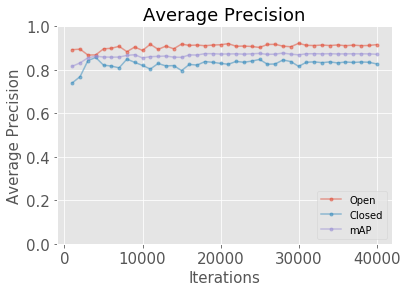

In [24]:
'''
Plot AP
'''
plot_path = csv_file[:-4] + '_result.png'
#path = caffe_root + 'models/gt_classifier/laptop/Results/Results_50000.csv'
df_plot = pd.read_csv(csv_file)
fig, ax1 = plt.subplots()

#Plotting training and test losses
Open, = ax1.plot(df_plot['#Iteration'], df_plot['Open'],  alpha=.5, marker='.')
Closed, = ax1.plot(df_plot['#Iteration'], df_plot['Closed'], alpha=.5,  marker='.')
mAP, = ax1.plot(df_plot['#Iteration'], df_plot['mAP'], alpha=.5,  marker='.')
ax1.set_ylim(ymin=0, ymax=1)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Average Precision', fontsize=15)
ax1.tick_params(labelsize=15)

plt.legend([Open, Closed,mAP], \
           ['Open', 'Closed', 'mAP'], \
           loc='lower right')
plt.title('Average Precision', fontsize=18)
#plt.show()
plt.savefig(plot_path)